In [7]:
import os

import pathlib

import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.legend import _get_legend_handles_labels

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [8]:
def compute_plot_Nemenyi(data, filename, baseline="uniform", model ="resnet50", dataset = "imagenet"):
    ranks = np.array([rankdata(-p) for p in data.values])
    average_ranks = np.mean(ranks, axis=0)
    cd = compute_CD(average_ranks,
                    n=data.shape[0],
                    alpha='0.05',
                    test='nemenyi')
    # This method generates the plot.
    graph_ranks(average_ranks,
                names=list(data),
                cd=cd,
                width=10,
                textspace=2,
                reverse=True)

    plt.savefig(f'{filename}_{model}_{dataset}_baseline_{baseline}.png')
    plt.close()

In [9]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [10]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [11]:
metrics =  ['Faithfulness Estimate', 'Faithfulness Correlation', 
            'Monotonicity Arya','Pixel-Flipping',
            "Selectivity", 'Monotonicity Nguyen']
    
transform = {'Monotonicity Nguyen': lambda x: x, 'Local Lipschitz Estimate': lambda x: -x, 
            'Faithfulness Estimate': abs, 'Faithfulness Correlation': abs, 
            'Avg-Sensitivity': lambda x: -x, 'Random Logit': lambda x: x,
             'Sparseness': lambda x: x, 'EffectiveComplexity': lambda x: -x,
             'Nonsensitivity': lambda x: -x, 'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
             'Max-Sensitivity': lambda x: -x, 'Complexity': lambda x: -x, 
             "Selectivity": lambda x: -parser_method_dict(x), 'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
             'Monotonicity Arya': lambda x: x,
            }
baselines = ["mean", "black", "white", "uniform", "random"]
    
methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam', 'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]



In [ ]:
metrics_full =['Monotonicity Nguyen',  'Local Lipschitz Estimate',
            'Faithfulness Estimate', 'Faithfulness Correlation', 
            'Avg-Sensitivity', 'Random Logit',
            'Max-Sensitivity', 'Sparseness', 
            'EffectiveComplexity',  'Monotonicity Arya',
             'Complexity', 'Pixel-Flipping',
            "Selectivity", 'Model Parameter Randomisation'] 


dico_baselines = {}

group_nemenyi = {}
df_ranks = {}

for base in baselines: 
    dico_ranks = {}
    for metr in metrics_full:        
        print("-- Metric: ", metr, base)
        data_nemenyi = pd.DataFrame()
        for meth in methods:
            if metr in metrics:
                csv_name = f"csv/baseline_{base}/{meth}_{model}_{dataset}_{metr}_baseline_{base}.csv"
                df = pd.read_csv(csv_name, header = None)
                data_nemenyi[meth] = transform[metr](df).values.flatten()
            else:
                csv_name = f"results/parsed_csv/processed_{meth}_{model}_{dataset}_{metr}"
                df = pd.read_csv(csv_name, index_col=0)
                df = df["value_per_image"]
                data_nemenyi[meth] = df.values.flatten()

        #data_nemenyi = transform[metr](data_nemenyi)

        ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
        average_ranks = np.mean(ranks, axis=0)

        dico_ranks[metr] = average_ranks/len(methods)

        result = sp.posthoc_nemenyi_friedman(data_nemenyi)
    #Order of methods is changed after being passed to the previous function
    #So reindex them before getting the groups from Nemenyi
    
        group_nemenyi[(metr,base)] = np.argwhere(result.reindex(methods)[methods].values > alpha)

    df_ranks[base] = pd.DataFrame(dico_ranks, index= methods)

df_ranks["uniform"]
#compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen mean
-- Metric:  Local Lipschitz Estimate mean
-- Metric:  Faithfulness Estimate mean
-- Metric:  Faithfulness Correlation mean
-- Metric:  Avg-Sensitivity mean
-- Metric:  Random Logit mean
-- Metric:  Max-Sensitivity mean
-- Metric:  Sparseness mean
-- Metric:  EffectiveComplexity mean
-- Metric:  Monotonicity Arya mean
-- Metric:  Complexity mean
-- Metric:  Pixel-Flipping mean
-- Metric:  Selectivity mean


In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

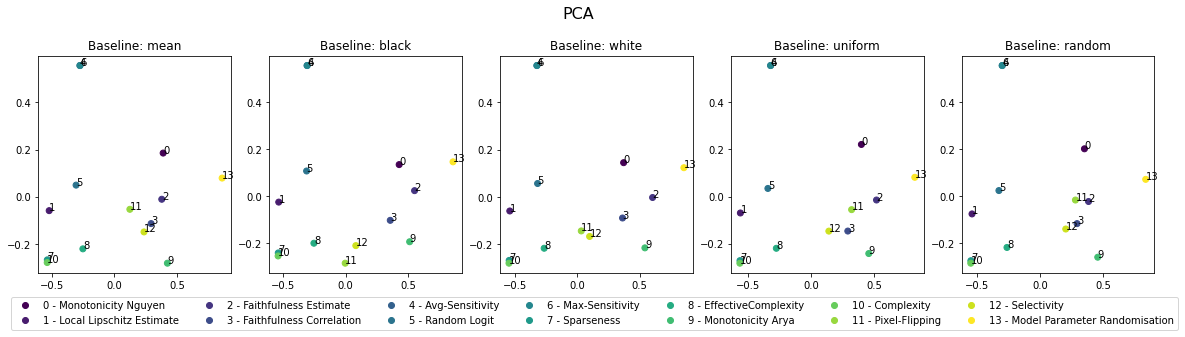

In [111]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=len(baselines))
variance_ratio = []
for b, base in enumerate(baselines):
    pca = PCA(n_components=2, svd_solver="full")
    df_ranks1 = df_ranks[base].transpose()
    pca.fit(df_ranks1)
    variance_ratio.append(sum(pca.explained_variance_ratio_))
    Z = pca.transform(df_ranks1)
    
    sct = ax[b].scatter(Z[:,0], Z[:,1], c= range(Z.shape[0]))
    ax[b].title.set_text(f"Baseline: {base}")
    for i, txt in enumerate(df_ranks1.index):
        ax[b].annotate(i, (Z[i,0], Z[i,1]))

    #plt.savefig(f"results/figures/variations/PCA_{base}.png", bbox_inches='tight')
fig.suptitle('PCA', fontsize=16, x=0.5, y=1.05)
fig.legend(handles=sct.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics_full)],
              loc = ('upper right'), ncol=7, bbox_to_anchor=(0.92, 0.06))
fig.savefig(f"results/figures/PCA.png", bbox_inches='tight')
plt.show()

In [112]:
print(np.mean(variance_ratio), np.std(variance_ratio))

0.7780676500127672 0.012464747045970854


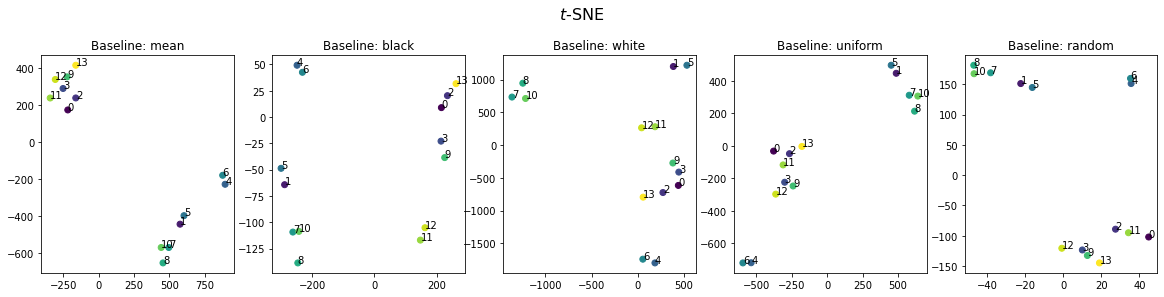

In [110]:
perp = 2
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=len(baselines))

for b, base in enumerate(baselines):
    tsne = TSNE(n_components=2, perplexity=perp,
                       init='random', random_state = 1234)
    df_ranks1 = df_ranks[base].transpose()
    X_embedded = tsne.fit_transform(df_ranks1.values)
    scatter = ax[b].scatter(X_embedded[:,0], X_embedded[:,1], c= range(X_embedded.shape[0]))
    ax[b].title.set_text(f"Baseline: {base}")

    for i, txt in enumerate(df_ranks1.index):
        ax[b].annotate(i, (X_embedded[i,0], X_embedded[i,1]))

    #plt.legend(handles=scatter.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics_full)],
    #          loc = (1.04,0))
    #plt.savefig(f"results/figures/variations/tsne_{base}.png", bbox_inches='tight')

fig.suptitle('$t$-SNE', fontsize=16, x=0.5, y=1.05)

fig.savefig(f"results/figures/tsne.png",  bbox_inches='tight')
plt.show()

In [113]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
